In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import optim

In [0]:
transform=transforms.Compose([transforms.ToTensor()])
trainset=datasets.MNIST('~/.pytorch/MNIST_data/',train=True,transform=transform,download=True)
testset=datasets.MNIST('~/.pytorch/MNIST_data/',train=False,transform=transform,download=True)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True,num_workers=0)
#will explain later
testloader=torch.utils.data.DataLoader(testset,batch_size=100,shuffle=True,num_workers=0)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        #self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(50, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
model=Network()
optimizer=optim.Adam(model.parameters(),lr=0.01)
criterion=nn.NLLLoss()

In [27]:
epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in trainloader:
        optimizer.zero_grad()
        #images=images.view(images.shape[0],-1)
        log_ps=model(images)
        loss=criterion(log_ps,labels) # a single value for ex 2.33
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.shape[0] ## (2.33*64 + 2.22*64 + 2.12*33) / 138 
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in testloader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels) *images.shape[0]
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.sum(equals).item()
        model.train()
        train_losses.append(running_loss/len(trainloader.dataset))
        test_losses.append(test_loss.item()/len(testloader.dataset))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader.dataset)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader.dataset)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader.dataset)))    

Epoch: 1/5..  Training Loss: 0.096..  Test Loss: 0.160..  Test Accuracy: 0.969
Epoch: 2/5..  Training Loss: 0.101..  Test Loss: 0.134..  Test Accuracy: 0.972
Epoch: 3/5..  Training Loss: 0.096..  Test Loss: 0.140..  Test Accuracy: 0.970
Epoch: 4/5..  Training Loss: 0.094..  Test Loss: 0.163..  Test Accuracy: 0.970
Epoch: 5/5..  Training Loss: 0.093..  Test Loss: 0.139..  Test Accuracy: 0.974


In [28]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc4.weight', 'fc4.bias'])


In [0]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [30]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc4.weight', 'fc4.bias'])


In [31]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [256,128,64],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [17]:
running_loss

9158.460867777467

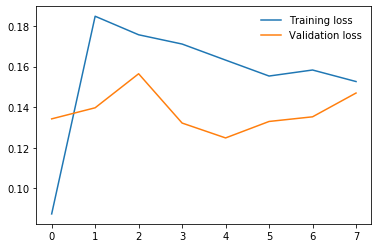

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [19]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
top_prob,top_class=ps.topk(1,dim=1)
top_class.item(),labels[0]

(8, tensor(8))

In [20]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([100, 784])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([50, 100])
fc2.bias 	 torch.Size([50])
fc4.weight 	 torch.Size([10, 50])
fc4.bias 	 torch.Size([10])


In [21]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {140460908964240: {'step': 7800, 'exp_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'exp_avg_sq': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}, 140460908964384: {'step': 7800, 'exp_avg': tensor([ 2.4382e-04,  3.0963e-06,  4.0452e-06,  7.0769e-05,  8.5835e-05,
        -6.3067e-04,  1.1524e-03, -6.9888e-05,  5.6052e-45,  5.8251e-04,
         5.6052e-45,  5.6052e-45, -9.0050e-04,  1.1031e-03,  5.6052e-45,
         5.6052e-45,  3.9605e-04,  7.7231e-04,  4.4290e-04, -6.1710e-04,
        -4.1801e-04,  1.8286e-03,  5.6052e-45, -1.8768e-04, -3.1

In [22]:
print("Our model: \n\n", model, '\n')


pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

Our model: 

 Network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



84060